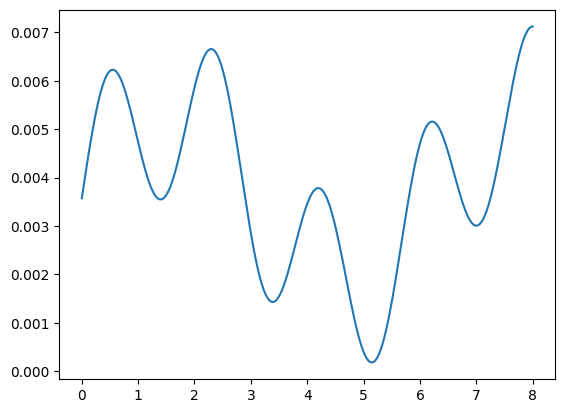

In [112]:
import numpy as np
def f(x):
    return (np.sin(x) + np.sin(10 * x / 3) + 2)/560

def gradient_f(x):
# gradient = d/dx (np.sin(x) + np.sin(10 * x / 3) + 2)/4
    return (np.cos(x) + (10/3)*np.cos(10 * x / 3))/560

import matplotlib.pyplot as plt

n_qubits=8
num_points=2**n_qubits

x_t = np.linspace(0,8,num_points,endpoint=True)

y_t = [ f(x_) for x_ in x_t ]

plt.plot(x_t,y_t)

In [113]:
# need to make sure the sum is normalized or at least less than 1
print(f'sum of f(x)\'s = {sum([f(x) for x in x_t])}')
print(f'sum of d/dx of f(x)\'s = {sum([gradient_f(x) for x in x_t])}')

sum of f(x)'s = 0.9976888663828525
sum of d/dx of f(x)'s = 0.11698725631379238


In [114]:
print(min(y_t),max(y_t))

0.00017929120181611508 0.007122640343577642


In [115]:
# mapping 0 - 2^qubits to actual data points
fixBinary = lambda x : x[2:] if len(x)-2 == n_qubits else '0'*(n_qubits+2-len(x)) + x.split('b')[1]
binary = lambda x: fixBinary(bin(x))
BinaryToDigit = {binary(x): x for x in range(0,2**n_qubits)}
BinaryToData = {binary(i): x_t[i] for i in range(0,2**n_qubits)}

In [116]:
def nestedKronecker(args): # use "*args" to access an array of inputs
    import numpy as np
    assert len(args) >= 2
    temp = args[0]
    for arg in args[1:]:
        temp = np.kron(temp, arg)
    return temp


In [117]:
import numpy as np
from qiskit.circuit.gate import Gate
from qiskit import QuantumCircuit,BasicAer,transpile
from qiskit.quantum_info.operators import Operator


In [118]:
#building the phase oracle manually: sum exponential with outer product of possible states
basis = {0: [1,0], 1: [0,1], '0': [1,0], '1': [0,1]}

createBasisVectorFromBinary = lambda binstr : nestedKronecker([basis[x] for x in binstr])

getPhase = lambda x : np.exp(2*np.pi*1j*(2**n_qubits)*f(x))

OracleOperator = np.zeros((2**n_qubits, 2**n_qubits), dtype=np.complex128)
for i in range(2**n_qubits):
    data_point = x_t[i]
    basisVector = createBasisVectorFromBinary(binary(i))
    OracleOperator += getPhase(data_point) * np.outer(basisVector, basisVector)

In [119]:
# create the Quantum Fourier Transform
def QFT():
    qft = QuantumCircuit(n_qubits, n_qubits)
    for target_q in range(n_qubits-1):
        qft.h(target_q)
        for control_q in range(target_q+1,n_qubits,1):
            k=target_q-control_q+1
            phase = 2*np.pi/(2**k)
            qft.cp(phase, control_q, target_q) #R_k gate
    qft.h(n_qubits-1)
    return qft

getUPhase = lambda x : np.exp(2*np.pi*1j*(-x*(0.5+2**(-n_qubits-1)) + (2**(n_qubits-2)-0.5+2**(-n_qubits-2))/2))

U = np.zeros((2**n_qubits, 2**n_qubits), dtype=np.complex128)
for x in range(2**n_qubits):
    basisVector = createBasisVectorFromBinary(binary(x))
    U += getUPhase(x) * np.outer(basisVector, basisVector)
QFT_n = Operator(QFT())
QFT_Gn = Operator(np.matmul(np.matmul(U,QFT_n.data), U))
QFT_Gn_inv = Operator(np.conjugate(np.transpose(QFT_Gn.data)))

In [120]:
# build the circuit
qc = QuantumCircuit(n_qubits,n_qubits)
qc.h([i for i in range(n_qubits)])
oracle = Operator(OracleOperator)
qc.unitary(oracle, range(n_qubits),label="Oracle_f")
qc.unitary(QFT_Gn_inv, range(n_qubits),label="QFT_Gn^(-1)")
qc.measure(range(n_qubits), range(n_qubits))
qc.draw()

┌───┐┌───────────┐┌──────────────┐┌─┐                     
q_0: ┤ H ├┤0          ├┤0             ├┤M├─────────────────────
     ├───┤│           ││              │└╥┘┌─┐                  
q_1: ┤ H ├┤1          ├┤1             ├─╫─┤M├──────────────────
     ├───┤│           ││              │ ║ └╥┘┌─┐               
q_2: ┤ H ├┤2          ├┤2             ├─╫──╫─┤M├───────────────
     ├───┤│           ││              │ ║  ║ └╥┘┌─┐            
q_3: ┤ H ├┤3          ├┤3             ├─╫──╫──╫─┤M├────────────
     ├───┤│  Oracle_f ││  QFT_Gn^(-1) │ ║  ║  ║ └╥┘┌─┐         
q_4: ┤ H ├┤4          ├┤4             ├─╫──╫──╫──╫─┤M├─────────
     ├───┤│           ││              │ ║  ║  ║  ║ └╥┘┌─┐      
q_5: ┤ H ├┤5          ├┤5             ├─╫──╫──╫──╫──╫─┤M├──────
     ├───┤│           ││              │ ║  ║  ║  ║  ║ └╥┘┌─┐   
q_6: ┤ H ├┤6          ├┤6             ├─╫──╫──╫──╫──╫──╫─┤M├───
     ├───┤│           ││              │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_7: ┤ H ├┤7          ├┤7             ├─╫──╫──╫──╫──╫──╫──╫─┤M├
     └───┘└───────────┘└──────────────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 8/═══════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                        0  1  2  3  4  5  6  7

In [121]:
n_shots = 100000
backend = BasicAer.get_backend('qasm_simulator')

job = backend.run(transpile(qc, backend, optimization_level=2), shots=n_shots)

res = job.result().get_counts() # dictionary of outcomes

In [123]:
print(len(res))

212


In [129]:
from bitstring import BitArray
rand_x = 68
bin_x = binary(rand_x)
data_point = BinaryToData[bin_x]
print(bin_x, ' => ', BitArray(bin=bin_x).int)
print(bin_x[::-1], ' => ', BitArray(bin=bin_x[::-1]).int) # reversed string
print(f'expected: f\'(x) = d\dx * f(x) = {gradient_f(data_point)}')
result1 = 'DNE' if bin_x not in res else res[bin_x]/n_shots
result2 = 'DNE' if bin_x[::-1] not in res else res[bin_x[::-1]]/n_shots
print(f'experimental: res[{bin_x}] = {result1}')
print(f'experimental: res[{bin_x[::-1]}] = {result2}')

01000100  =>  68
00100010  =>  34
expected: f'(x) = d\dx * f(x) = 0.0030738376678281767
experimental: res[01000100] = 5e-05
experimental: res[00100010] = DNE
